In [1]:
from diabetic_env_ethan import Diabetic2Env
import gym
import numpy as np
import random
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from torch.optim import Adam

In [11]:
class RewardPlottingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(RewardPlottingCallback, self).__init__(verbose)
        self.rewards = []
        self.episode_rewards = []
        self.episode_lengths = []
        self.episode_count = 0

    def _on_step(self):
        # Capture rewards and keep track of episode lengths
        self.rewards.append(self.locals['rewards'])
        if self.locals['dones'][0]:
            self.episode_count += 1
            self.episode_rewards.append(sum(self.rewards))
            self.episode_lengths.append(len(self.rewards))
            self.rewards = []
        return True

    def _on_training_end(self):
        # Plot the rewards and lengths at the end of training
        self.plot_rewards()

    def plot_rewards(self):
        plt.figure(figsize=(12, 6))
        
        # Plot Episode Rewards
        plt.subplot(2, 1, 1)
        plt.plot(self.episode_rewards, label='Episode Rewards')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Cumulative Rewards per Episode')
        plt.legend()

        plt.tight_layout()
        plt.show()

In [3]:
diabetic_sim = Diabetic2Env()

In [4]:
diabetic_sim.set_episode_length(10)

In [17]:
model = DQN(
        "MlpPolicy",
        diabetic_sim,
        verbose=1,
        train_freq=16,
        gradient_steps=8,
        gamma=0.99,
        exploration_fraction=0.2,
        exploration_final_eps=0.07,
        target_update_interval=600,
        learning_starts=1000,
        buffer_size=10000,
        batch_size=128,
        learning_rate=4e-4,
        policy_kwargs=dict(net_arch=[256, 256]),
        seed=2,
)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [18]:
mean_reward, std_reward = evaluate_policy(
    model,
    diabetic_sim,
    deterministic=True,
    n_eval_episodes=20,
)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:-141.68 +/- 0.59


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -122     |
|    exploration_rate | 0.945    |
| time/               |          |
|    episodes         | 10       |
|    fps              | 1598     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1430     |
| train/              |          |
|    learning_rate    | 0.0004   |
|    loss             | 2.72     |
|    n_updates        | 216      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 143      |
|    ep_rew_mean      | -119     |
|    exploration_rate | 0.889    |
| time/               |          |
|    episodes         | 20       |
|    fps              | 1142     |
|    time_elapsed     | 2        |
|    total_timesteps  | 2860     |
| train/              |          |
|    learning_rate    | 0.0004   |
|    loss             | 5.17     |
|    n_updates      

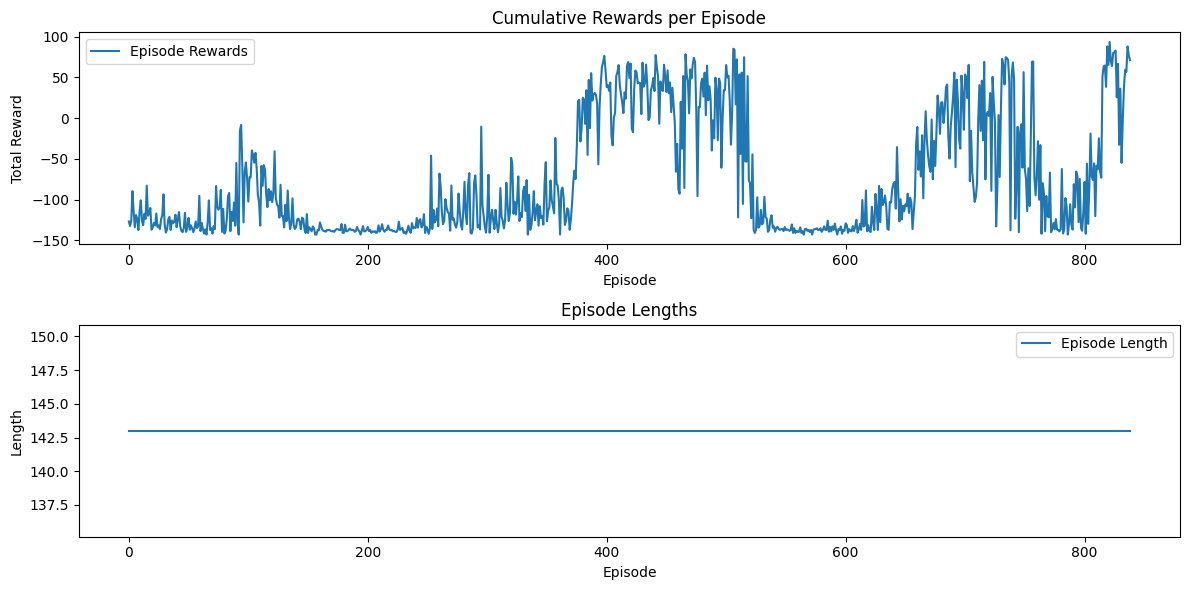

In [19]:
# model.learn(total_timesteps=10000, callback=RewardPlottingCallback(), log_interval=4)
model.learn(int(1.2e5), callback=RewardPlottingCallback(), log_interval=10)

In [20]:
model.save("dqn_diabetes_1")

In [21]:
mean_reward, std_reward = evaluate_policy(model, diabetic_sim, deterministic=True, n_eval_episodes=20)

print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:90.59 +/- 4.73


In [22]:
test_model = DQN.load("dqn_diabetes")

In [24]:
total_rewards = []
for episode in range(100):
    state = diabetic_sim.reset()
    done = False
    total_reward = 0

    while not done:
        action, _states = test_model.predict(state, deterministic=True)
        next_state, reward, done, info = diabetic_sim.step(action)
        total_reward += reward
        state = next_state

    total_rewards.append(total_reward)
    # diabetic_sim.render()

average_reward = sum(total_rewards) / 100
print(f"Average Reward: {average_reward}")

Average Reward: 99.03197761229654
